# **K-Fold training**


In [1]:
# Enviroment
isColab = False
colab_dir = "/gdrive/My Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2"

isKaggle = False
isWsl = True

# Set seed for reproducibility
SEED = 46

## **Loading Enviroment**


In [2]:
import os

# Directory di default
current_dir = os.getcwd()   

if isColab:
    from google.colab import drive # type: ignore
    drive.mount("/gdrive")
    current_dir = colab_dir
    print("In esecuzione su Colab. Google Drive montato.")
    %cd $current_dir
elif isKaggle:
    kaggle_work_dir = "/kaggle/working/AN2DL-challenge-2"
    os.makedirs(kaggle_work_dir, exist_ok=True)
    current_dir = kaggle_work_dir
    print("In esecuzione su Kaggle. Directory di lavoro impostata.")
    os.chdir(current_dir)
elif isWsl:
    local_pref = r"/mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2"
    current_dir = local_pref if os.path.isdir(local_pref) else os.getcwd()
    print(f"Esecuzione su WSL. Directory corrente impostata a: {current_dir}")
    os.chdir(current_dir)
else:
    print("Esecuzione locale. Salto mount Google Drive.")
    local_pref = r"G:\Il mio Drive\Colab Notebooks\[2025-2026] AN2DL\AN2DL-challenge-2"
    current_dir = local_pref if os.path.isdir(local_pref) else os.getcwd()
    print(f"Directory corrente impostata a: {current_dir}")
    os.chdir(current_dir)

print(f"Changed directory to: {current_dir}")

# Define absolute paths
dataset_dir = os.path.join(current_dir, "dataset")
train_set_dir = os.path.join(dataset_dir, "train_data")
test_set_dir = os.path.join(dataset_dir, "test_data")
label_file = os.path.join(dataset_dir, "train_labels.csv")

print(f"Dataset directory: {dataset_dir}")
print(f"Train set directory: {train_set_dir}")
print(f"Test set directory: {test_set_dir}")
print(f"Label file: {label_file}")

Esecuzione su WSL. Directory corrente impostata a: /mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2
Changed directory to: /mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2
Dataset directory: /mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2/dataset
Train set directory: /mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2/dataset/train_data
Test set directory: /mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2/dataset/test_data
Label file: /mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2/dataset/train_labels.csv


## **Import Libraries**


In [3]:
# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader


# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
if isColab or isKaggle:
    !pkill -f tensorboard 
    !mkdir -p models
    print("Killed existing TensorBoard instances and created models directory.") 

os.makedirs("models", exist_ok=True)  

%load_ext tensorboard


if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import shutil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import  DataLoader
from torch.optim import AdamW

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

PyTorch version: 2.9.1+cu130
Device: cuda


### **Preparing Dataset for colab**


In [4]:
if isColab:
    drive_dataset_dir = os.path.join(current_dir, "dataset")
    local_dataset_dir = "/content/dataset"

    if not os.path.exists(local_dataset_dir):
        print(f"Copying dataset from {drive_dataset_dir} to {local_dataset_dir}...")
        try:
            shutil.copytree(drive_dataset_dir, local_dataset_dir)
            print("Copy complete.")
        except Exception as e:
            print(f"Error copying dataset: {e}")
            print("Falling back to Drive dataset (slow).")
            # If copy fails, we stick to the original dataset_dir (which might need cleaning too if it was used directly)
            dataset_dir = drive_dataset_dir
    else:
        print("Dataset already copied to local runtime.")

    # If copy succeeded (or already existed), use local path
    if os.path.exists(local_dataset_dir):
        dataset_dir = local_dataset_dir

## ⏳ **Data Loading**


In [5]:
# Loader parameters
BATCH_SIZE = 128
GRAD_ACCUMULATION_STEPS = 1

NORMALIZATION_MEAN = [0.485, 0.456, 0.406]
NORMALIZATION_STD = [0.229, 0.224, 0.225]

MASK_THRESHOLD = 0.01
OVERLAP_RATIO = 0.3

IMG_RESIZE = (224, 224)
INPUT_SHAPE = (3, *IMG_RESIZE)

### **Definitions**


In [6]:
SAMPLES_TO_IGNORE = [
    "img_0001.png",
    "img_0005.png",
    "img_0008.png",
    "img_0012.png",
    "img_0018.png",
    "img_0020.png",
    "img_0022.png",
    "img_0027.png",
    "img_0028.png",
    "img_0036.png",
    "img_0044.png",
    "img_0047.png",
    "img_0048.png",
    "img_0052.png",
    "img_0062.png",
    "img_0078.png",
    "img_0085.png",
    "img_0090.png",
    "img_0094.png",
    "img_0095.png",
    "img_0126.png",
    "img_0129.png",
    "img_0130.png",
    "img_0133.png",
    "img_0136.png",
    "img_0138.png",
    "img_0148.png",
    "img_0150.png",
    "img_0155.png",
    "img_0159.png",
    "img_0161.png",
    "img_0175.png",
    "img_0178.png",
    "img_0179.png",
    "img_0180.png",
    "img_0184.png",
    "img_0187.png",
    "img_0189.png",
    "img_0193.png",
    "img_0196.png",
    "img_0222.png",
    "img_0251.png",
    "img_0254.png",
    "img_0263.png",
    "img_0268.png",
    "img_0286.png",
    "img_0293.png",
    "img_0313.png",
    "img_0319.png",
    "img_0333.png",
    "img_0342.png",
    "img_0344.png",
    "img_0346.png",
    "img_0355.png",
    "img_0368.png",
    "img_0371.png",
    "img_0376.png",
    "img_0380.png",
    "img_0390.png",
    "img_0393.png",
    "img_0407.png",
    "img_0410.png",
    "img_0415.png",
    "img_0424.png",
    "img_0443.png",
    "img_0453.png",
    "img_0459.png",
    "img_0463.png",
    "img_0486.png",
    "img_0497.png",
    "img_0498.png",
    "img_0499.png",
    "img_0509.png",
    "img_0521.png",
    "img_0530.png",
    "img_0531.png",
    "img_0533.png",
    "img_0537.png",
    "img_0540.png",
    "img_0544.png",
    "img_0547.png",
    "img_0557.png",
    "img_0558.png",
    "img_0560.png",
    "img_0565.png",
    "img_0567.png",
    "img_0572.png",
    "img_0578.png",
    "img_0580.png",
    "img_0586.png",
    "img_0602.png",
    "img_0603.png",
    "img_0607.png",
    "img_0609.png",
    "img_0614.png",
    "img_0620.png",
    "img_0623.png",
    "img_0629.png",
    "img_0635.png",
    "img_0639.png",
    "img_0643.png",
    "img_0644.png",
    "img_0645.png",
    "img_0646.png",
    "img_0656.png",
    "img_0657.png",
    "img_0658.png",
    "img_0670.png",
    "img_0673.png",
    "img_0675.png",
]

In [7]:
# Load the full dataframe
full_df = pd.read_csv(label_file)

# Remove cursed images
full_df = full_df[~full_df["sample_index"].isin(SAMPLES_TO_IGNORE)].reset_index(
    drop=True
)

# Label mapping
class_names = sorted(full_df["label"].unique())
label_to_index = {name: idx for idx, name in enumerate(class_names)}
full_df["label_index"] = full_df["label"].map(label_to_index)
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")

Number of classes: 4


In [8]:
def make_loader(ds, batch_size, shuffle, drop_last=False):
    """Create a PyTorch DataLoader with optimized settings."""
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(6, cpu_cores))

    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,
        persistent_workers=True,
    )

In [80]:
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm


def get_macenko_stats(img_arr, Io=240, alpha=1, beta=0.18):
    """
    Extracts the Stain Matrix (HE) and Max Concentrations (maxC)
    from a single image WITHOUT normalizing it.
    """
    # 1. Convert to OD
    h, w, c = img_arr.shape
    img_arr = img_arr.reshape((-1, 3))
    OD = -np.log((img_arr.astype(np.float64) + 1) / Io)

    # 2. Remove transparent pixels
    ODhat = OD[~np.any(OD < beta, axis=1)]
    if ODhat.shape[0] < 10:
        return None, None

    # 3. Compute SVD
    _, eigvecs = np.linalg.eigh(np.cov(ODhat.T))

    # 4. Project on the plane spanned by the eigenvectors corresponding to the two largest eigenvalues
    That = ODhat.dot(eigvecs[:, -2:])

    # 5. Find robust extremes (1st and 99th percentiles)
    phi = np.arctan2(That[:, 1], That[:, 0])
    minPhi = np.percentile(phi, alpha)
    maxPhi = np.percentile(phi, 100 - alpha)

    vMin = eigvecs[:, -2:].dot(np.array([(np.cos(minPhi), np.sin(minPhi))]).T)
    vMax = eigvecs[:, -2:].dot(np.array([(np.cos(maxPhi), np.sin(maxPhi))]).T)

    # 6. Heuristic to ensure H is first vector, E is second
    if vMin[0] > vMax[0]:
        HE = np.array((vMin[:, 0], vMax[:, 0])).T
    else:
        HE = np.array((vMax[:, 0], vMin[:, 0])).T

    # 7. Calculate Max Concentrations
    Y = np.reshape(OD, (-1, 3)).T
    C = np.linalg.lstsq(HE, Y, rcond=None)[0]
    maxC = np.percentile(C, 99, axis=1)

    return HE, maxC


In [81]:
def calibrate_macenko_reference_masked(df, img_dir, num_samples=200):
    """
    Calculates Macenko stats ONLY on the tissue regions defined by the masks.
    """
    print(f"Calibrating Macenko (Masked) on {num_samples} slides...")

    sample_df = df.sample(n=num_samples, random_state=SEED).reset_index(drop=True)

    all_HE = []
    all_maxC = []

    for i, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
        img_name = row["sample_index"]
        mask_name = img_name.replace("img_", "mask_")

        img_path = os.path.join(img_dir, img_name)
        mask_path = os.path.join(img_dir, mask_name)

        try:
            # 1. Load Image and Mask
            img = Image.open(img_path).convert("RGB")
            mask = Image.open(mask_path).convert("L")  # Grayscale

            # 2. Apply Mask: Create a blank white image
            # We want to keep the image ONLY where mask > 0
            # Where mask == 0, we make it White (255) so Macenko ignores it (OD ~ 0)
            white_bg = Image.new("RGB", img.size, (255, 255, 255))
            masked_img = Image.composite(img, white_bg, mask)

            # 3. Convert to Array for Macenko
            img_arr = np.array(masked_img)

            # 4. Extract stats (The white pixels will be filtered by beta=0.15 inside this function)
            he, max_c = get_macenko_stats(img_arr)

            if he is not None:
                all_HE.append(he)
                all_maxC.append(max_c)

        except Exception as e:
            # print(f"Skipping {img_name}: {e}")
            continue

    if len(all_HE) == 0:
        print("❌ Error: No valid tumor regions found in samples!")
        return None, None

    # Compute Robust Averages
    avg_HE = np.median(np.array(all_HE), axis=0)
    avg_maxC = np.median(np.array(all_maxC), axis=0)

    print("\n✅ MASKED CALIBRATION COMPLETE.")
    print("Use these values in MacenkoNormalizer:")
    print("-" * 40)
    print(f"self.HERef = np.array({avg_HE.tolist()})")
    print(f"self.maxCRef = np.array({avg_maxC.tolist()})")
    print("-" * 40)

    return avg_HE, avg_maxC


In [82]:
new_HE, new_maxC = calibrate_macenko_reference_masked(full_df, train_set_dir, num_samples=100)

Calibrating Macenko (Masked) on 100 slides...


  0%|          | 0/100 [00:00<?, ?it/s]


✅ MASKED CALIBRATION COMPLETE.
Use these values in MacenkoNormalizer:
----------------------------------------
self.HERef = np.array([[0.5608333674988369, 0.49390547104405746], [0.6451505907156044, 0.7493755444865834], [0.5147759897497383, 0.45420162477922627]])
self.maxCRef = np.array([0.11379705088151437, 0.22656255075491988])
----------------------------------------


In [ ]:
import numpy as np


class MacenkoNormalizer:
    """
    Normalizes H&E stained images to a reference appearance using the Macenko method.
    """

    def __init__(self, he=None, max_c=None):

        if he.all():
            self.HERef = he
        else:
            self.HERef = np.array(
                [[0.5626, 0.2159], [0.7201, 0.8012], [0.4062, 0.5581]]
            )

        if max_c.all():
            self.maxCRef = max_c * 5.0
        else:
            self.maxCRef = np.array([1.9705, 1.0308])

    def __call__(self, img_arr, Io=240, alpha=1, beta=0.18):
        """
        img_arr: RGB numpy array (H, W, 3)
        Returns: Normalized numpy array
        """
        # 1. Convert to Optical Density (OD)
        h, w, c = img_arr.shape
        img_arr = img_arr.reshape((-1, 3))

        # Avoid division by zero
        OD = -np.log((img_arr.astype(np.float64) + 1) / Io)

        # 2. Remove transparent pixels
        ODhat = OD[~np.any(OD < beta, axis=1)]
        if ODhat.shape[0] < 10:  # Safety check for empty patches
            return img_arr.reshape(h, w, c).copy()

        # 3. Compute SVD
        _, eigvecs = np.linalg.eigh(np.cov(ODhat.T))

        # 4. Project on the plane spanned by the eigenvectors corresponding to the two largest eigenvalues
        That = ODhat.dot(eigvecs[:, -2:])

        # 5. Find robust extremes (1st and 99th percentiles)
        phi = np.arctan2(That[:, 1], That[:, 0])
        minPhi = np.percentile(phi, alpha)
        maxPhi = np.percentile(phi, 100 - alpha)

        vMin = eigvecs[:, -2:].dot(np.array([(np.cos(minPhi), np.sin(minPhi))]).T)
        vMax = eigvecs[:, -2:].dot(np.array([(np.cos(maxPhi), np.sin(maxPhi))]).T)

        # 6. Heuristic to ensure H is first vector, E is second
        if vMin[0] > vMax[0]:
            HE = np.array((vMin[:, 0], vMax[:, 0])).T
        else:
            HE = np.array((vMax[:, 0], vMin[:, 0])).T

        # 7. Rows correspond to channels (RGB), columns to H&E stains
        Y = np.reshape(OD, (-1, 3)).T

        # Determine concentrations of the individual stains
        C = np.linalg.lstsq(HE, Y, rcond=None)[0]

        # 8. Normalize concentrations
        maxC = np.percentile(C, 99, axis=1)
        tmp = np.divide(maxC, self.maxCRef)
        C2 = np.divide(C, tmp[:, np.newaxis])

        # 9. Reconstruct the image
        Inorm = np.multiply(Io, np.exp(-self.HERef.dot(C2)))
        
        # SAFETY CLIP: Ensure no values exceed 255 or go below 0
        Inorm = np.clip(Inorm, 0, 255)
        
        Inorm = np.reshape(Inorm.T, (h, w, 3)).astype(np.uint8)
        return Inorm

In [84]:
from PIL import Image, ImageOps
from torch.utils.data import Dataset
from tqdm.notebook import tqdm


class MaskedGridTileDataset(Dataset):
    """
    A Dataset class that performs Grid Tiling over the tissue masks.
    It extracts patches based on a sliding window, keeping only those
    that contain sufficient biological tissue.
    """

    def __init__(
        self,
        dataframe,
        img_dir,
        transforms=None,
        target_size=(300, 300),
        mask_threshold=0.05,  # Keep patch if at least 5% is tissue
        overlap_ratio=0.0,  # 0.0 = distinct tiles; 0.5 = 50% overlap
        normalize=True,
        debug_max=None,
    ):
        self.samples = []
        self.transforms = transforms
        self.img_dir = img_dir
        self.target_size = target_size
        self.mask_threshold = mask_threshold
        self.overlap_ratio = overlap_ratio
        self.normalizer = MacenkoNormalizer(new_HE, new_maxC) if normalize else None
        self.dropped_slides = 0

        # Determine if we are in inference mode (no labels)
        if dataframe is None or "label_index" not in dataframe.columns:
            # We are in inference mode
            if dataframe is None:
                img_names = sorted(
                    [f for f in os.listdir(img_dir) if f.startswith("img_")]
                )
            else:
                img_names = dataframe["sample_index"].tolist()
            iterator = zip(img_names, [-1] * len(img_names))
            total_items = len(img_names)
        else:
            iterator = zip(dataframe["sample_index"], dataframe["label_index"])
            total_items = len(dataframe)

        print(
            f"Processing {total_items} slides with Grid Tiling (Thr={mask_threshold}, Overlap={overlap_ratio})..."
        )

        count = 0
        for img_name, label in tqdm(iterator, total=total_items, leave=False):
            if debug_max and count >= debug_max:
                break
            self._process_and_extract(img_name, label)
            count += 1

        print(f"Extraction complete. Total patches: {len(self.samples)}")
        if self.dropped_slides > 0:
            print(
                f"⚠️ Warning: {self.dropped_slides} slides were completely empty/corrupt."
            )

    def _process_and_extract(self, img_name, label):
        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.img_dir, img_name.replace("img_", "mask_"))

        try:
            image = Image.open(img_path).convert("RGB")
            mask = Image.open(mask_path).convert("L")
        except Exception as e:
            print(f"Warning: Could not load {img_name}: {e}")
            self.dropped_slides += 1
            return

        img_w, img_h = image.size
        tile_h, tile_w = self.target_size

        # Calculate stride based on overlap
        stride_h = int(tile_h * (1 - self.overlap_ratio))
        stride_w = int(tile_w * (1 - self.overlap_ratio))

        # Ensure stride is at least 1 pixel to prevent infinite loops
        stride_h = max(1, stride_h)
        stride_w = max(1, stride_w)

        mask_arr = np.array(mask)
        # Binarize mask (assuming any non-zero value is tissue)
        binary_mask = (mask_arr > 0).astype(np.uint8)

        # Iterate via sliding window
        # We allow y and x to go slightly out of bounds to catch edges, handled by padding later
        for y in range(0, img_h, stride_h):
            for x in range(0, img_w, stride_w):

                # Define current window coordinates
                x2 = x + tile_w
                y2 = y + tile_h

                # --- 1. MASK CHECK (Fast filtering) ---
                # Clip coordinates to image bounds for the mask check
                mx1, my1 = x, y
                mx2, my2 = min(x2, img_w), min(y2, img_h)

                # Extract the mask patch corresponding to this tile
                mask_patch = binary_mask[my1:my2, mx1:mx2]

                # If the patch is empty or purely padding, skip
                if mask_patch.size == 0:
                    continue

                # Calculate tissue percentage
                tissue_pixels = np.count_nonzero(mask_patch)
                total_pixels = tile_w * tile_h  # Use theoretical size

                # If we are on the edge, the actual mask_patch might be smaller,
                # but we normalize by the Target Tile Size to penalize mostly-empty edge crops.
                tissue_coverage = tissue_pixels / total_pixels

                if tissue_coverage < self.mask_threshold:
                    continue

                # --- 2. IMAGE EXTRACTION (Only if mask check passed) ---
                # Handle Edge Padding
                # If x2 > img_w or y2 > img_h, we need to crop what we can and pad the rest

                # Actual crop coordinates within image
                crop_x1, crop_y1 = x, y
                crop_x2, crop_y2 = min(x2, img_w), min(y2, img_h)

                patch_crop = image.crop((crop_x1, crop_y1, crop_x2, crop_y2))

                # Calculate padding needed
                pad_right = max(0, x2 - img_w)
                pad_bottom = max(0, y2 - img_h)

                if pad_right > 0 or pad_bottom > 0:
                    # Pad with white (255) for histology background
                    patch = ImageOps.expand(
                        patch_crop, border=(0, 0, pad_right, pad_bottom), fill=255
                    )
                else:
                    patch = patch_crop

                # Final safeguard on size
                if patch.size != self.target_size:
                    patch = patch.resize(self.target_size, Image.BICUBIC) # type: ignore

                patch_arr = np.array(patch)

                if self.normalizer:
                    try:
                        # Macenko needs robust pixel data. If patch is mostly white/padding,
                        # it might fail or look weird. We only run it if we have tissue.
                        patch_arr = self.normalizer(patch_arr)
                    except Exception as e:
                        # Fallback if SVD fails on weird patches
                        print(f"Normalization failed on patch from {img_name} at ({x},{y}): {e}")
                        pass

                # Store in RAM
                self.samples.append(
                    {"patch": patch_arr, "label": label, "parent": img_name}
                )

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        item = self.samples[idx]
        img = Image.fromarray(item["patch"])
        label = item["label"]

        if self.transforms:
            img = self.transforms(img)

        return img, label, item["parent"]

### **Recomputing mean and std for normalization**

In [85]:
from torchvision.transforms import v2 as transforms


def compute_dataset_stats(
    dataset_class,
    dataframe,
    img_dir,
    target_size=IMG_RESIZE,
    mask_threshold=0.05,
    overlap_ratio=0.0,
    normalize=False,
    sample_fraction=0.2,  # <--- NEW PARAMETER (Default 20% of data)
    random_seed=42,
):
    """
    Computes channel-wise Mean and Std on a random subset of the dataset.
    """

    # 1. SAMPLING STEP
    if sample_fraction < 1.0:
        print(f"Subsampling dataset to {sample_fraction*100}% for stats calculation...")
        # We use groupby to ensure we keep proportional representation of all classes (Stratified)
        sampled_df = (
            dataframe.groupby("label", group_keys=False)
            .apply(lambda x: x.sample(frac=sample_fraction, random_state=random_seed))
            .reset_index(drop=True)
        )

        print(f"Original slides: {len(dataframe)} -> Sampled slides: {len(sampled_df)}")
    else:
        sampled_df = dataframe

    print("Computing dataset Mean and Std (this may take a moment)...")

    # define a simple transform that only converts to tensor
    basic_transforms = transforms.Compose(
        [transforms.Resize(target_size), transforms.ToTensor()]
    )

    # Instantiate dataset with the SAMPLED dataframe
    temp_ds = dataset_class(
        sampled_df,  # <--- Use sampled DF
        img_dir,
        transforms=basic_transforms,
        target_size=target_size,
        mask_threshold=mask_threshold,
        overlap_ratio=overlap_ratio,
        normalize=normalize,
    )

    # We can also increase batch size here since we aren't training (no backprop graph)
    # doubling batch size speeds up loading
    loader = make_loader(temp_ds, batch_size=BATCH_SIZE * 2, shuffle=False)

    mean = 0.0
    std = 0.0
    nb_samples = 0.0

    for data, _, _ in tqdm(loader, desc="Calculating Stats", leave=False):
        batch_samples = data.size(0)
        # Flatten H and W to calculate stats per channel
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples

    print(f"\nDONE. Copy these values into your config:")
    print(f"NEW_MEAN = {mean.tolist()}")
    print(f"NEW_STD = {std.tolist()}")
    return mean.tolist(), std.tolist()

In [86]:
print("Calculating stats on Training Data...")

# We use the class we just defined
custom_mean, custom_std = compute_dataset_stats(
    dataset_class=MaskedGridTileDataset,
    dataframe=full_df,
    img_dir=train_set_dir,
    target_size=IMG_RESIZE,
    mask_threshold=MASK_THRESHOLD,
    overlap_ratio=0.0,
    normalize=True,
    sample_fraction=0.2,  # Use 20% of data for stats
    random_seed=SEED,
)

NORMALIZATION_MEAN = custom_mean
NORMALIZATION_STD = custom_std

Calculating stats on Training Data...
Subsampling dataset to 20.0% for stats calculation...
Original slides: 581 -> Sampled slides: 117
Computing dataset Mean and Std (this may take a moment)...
Using calibrated maxCRef: [0.56898525 1.13281275]
Processing 117 slides with Grid Tiling (Thr=0.01, Overlap=0.0)...


  0%|          | 0/117 [00:00<?, ?it/s]

Extraction complete. Total patches: 580


Calculating Stats:   0%|          | 0/3 [00:00<?, ?it/s]


DONE. Copy these values into your config:
NEW_MEAN = [0.7009560465812683, 0.6456019878387451, 0.7174623608589172]
NEW_STD = [0.079030342400074, 0.10736365616321564, 0.07500480115413666]


### **Transforms**


In [87]:
# Define transformations

train_transform_tl = transforms.Compose(
    [
        transforms.Resize(IMG_RESIZE),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=NORMALIZATION_MEAN, std=NORMALIZATION_STD),
    ]
)

train_transform_ft = transforms.Compose(
    [
        transforms.RandomResizedCrop(
            IMG_RESIZE, scale=(0.8, 1.0), ratio=(0.8, 1.2), antialias=True
        ),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=180),  # type: ignore
        transforms.RandomApply(
            [transforms.ElasticTransform(alpha=50.0, sigma=5.0)], p=0.25
        ),
        transforms.RandomApply(
            [transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2.0))], p=0.2
        ),
        transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.05),
        #transforms.RandAugment(num_ops=2, magnitude=5),
        transforms.ToTensor(),
        transforms.Normalize(mean=NORMALIZATION_MEAN, std=NORMALIZATION_STD),
        #transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), ratio=(0.3, 3.3), value="random"  # type: ignore),
    ]
)

data_transforms = transforms.Compose(
    [
        transforms.Resize(IMG_RESIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=NORMALIZATION_MEAN, std=NORMALIZATION_STD),
    ]
)

### **A couple of visualizations**

In [88]:
import matplotlib.pyplot as plt
import numpy as np


def visualize_dataset_samples(dataset, num_samples=5, class_names=None):
    """
    Visualizes random samples from the dataset to verify:
    1. Tissue masking (patches should contain tissue, not just white background)
    2. Normalization/Augmentation (images should look valid)

    Args:
        dataset: The PyTorch Dataset object
        num_samples: Number of images to display
        class_names: List of class names strings (optional) to map label indices
    """
    # Create plot
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 4))

    # Pick random indices
    if len(dataset) < num_samples:
        indices = range(len(dataset))
    else:
        indices = np.random.choice(len(dataset), num_samples, replace=False)

    for i, idx in enumerate(indices):
        # 1. Get Data
        # __getitem__ returns: img_tensor, label, parent_id
        img_tensor, label, parent_id = dataset[idx]

        # 2. Un-Normalize
        # The tensor is (C, H, W) in range like [-2, 2] due to normalization.
        # We need (H, W, C) in range [0, 1] for matplotlib.
        img = img_tensor.permute(1, 2, 0).numpy()

        # Reverse the normalization formula: pixel = (pixel * std) + mean
        mean = np.array(NORMALIZATION_MEAN)
        std = np.array(NORMALIZATION_STD)
        img = (img * std) + mean

        # Clip to [0,1] range to avoid matplotlib warnings for slightly out-of-bound values
        img = np.clip(img, 0, 1)

        # 3. Plot
        ax = axes[i] if num_samples > 1 else axes
        ax.imshow(img)

        # Title with metadata
        label_name = class_names[label] if class_names else f"Class {label}"
        ax.set_title(f"{label_name}\n{parent_id}", fontsize=9)
        ax.axis("off")

    plt.tight_layout()
    plt.show()
    print(f"Displaying {num_samples} patches from {len(dataset)} total samples.")


Sub-sampling 5 real slides for visualization...
Using calibrated maxCRef: [0.56898525 1.13281275]
Processing 5 slides with Grid Tiling (Thr=0.1, Overlap=0.2)...


  0%|          | 0/5 [00:00<?, ?it/s]

Extraction complete. Total patches: 5

Visualizing 5 patches extracted from these slides...


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 291, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times


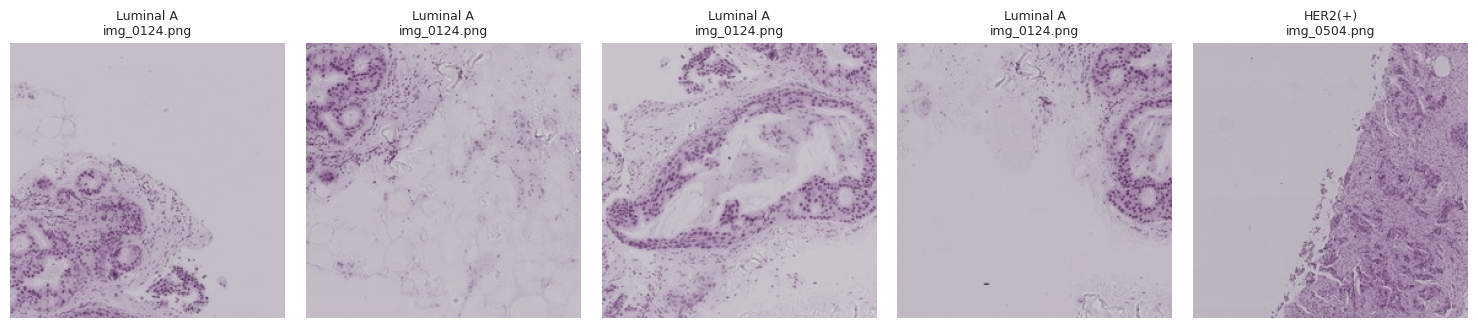

Displaying 5 patches from 5 total samples.


In [89]:
# 1. Sample 5 random slides from the full dataframe
# We do this to avoid waiting for the entire dataset to process
small_sample_df = full_df.sample(n=5, random_state=42).reset_index(drop=True)

print(f"Sub-sampling {len(small_sample_df)} real slides for visualization...")

# 2. Instantiate the Dataset with ONLY these 5 slides
# We use validation settings (no overlap) to see the 'pure' tiles
sample_ds = MaskedGridTileDataset(
    dataframe=small_sample_df,
    img_dir=train_set_dir,
    transforms=train_transform_tl,
    target_size=IMG_RESIZE,
    mask_threshold=0.1,
    overlap_ratio=0.2,
    normalize=True,  # Apply Macenko to see the normalized color
)

# 3. Visualize using the helper function
print(f"\nVisualizing {len(sample_ds)} patches extracted from these slides...")
# We use the function I provided in the previous step
visualize_dataset_samples(sample_ds, num_samples=5, class_names=class_names)

Using calibrated maxCRef: [0.56898525 1.13281275]
Processing 5 slides with Grid Tiling (Thr=0.1, Overlap=0.2)...


  0%|          | 0/5 [00:00<?, ?it/s]

Extraction complete. Total patches: 5

Visualizing 5 patches extracted from these slides...


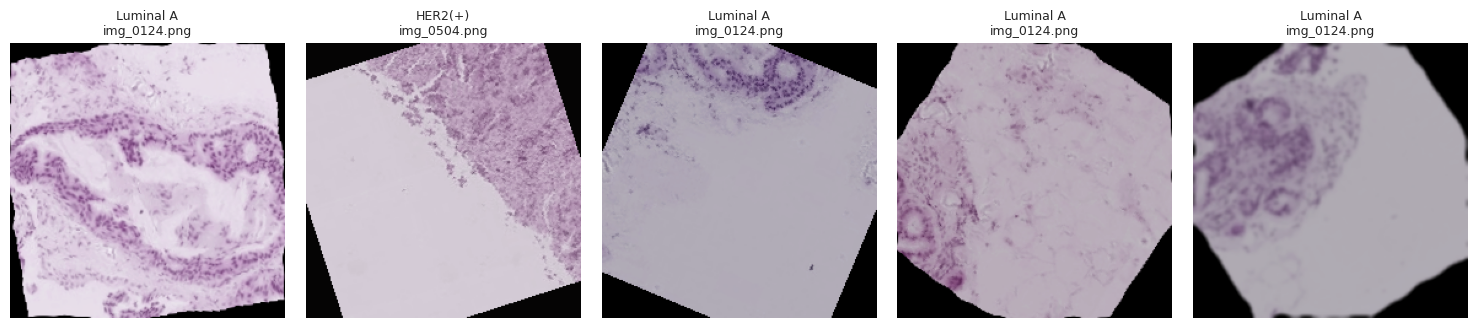

Displaying 5 patches from 5 total samples.


In [91]:

sample_ds = MaskedGridTileDataset(
    dataframe=small_sample_df,
    img_dir=train_set_dir,
    transforms=train_transform_ft,
    target_size=IMG_RESIZE,
    mask_threshold=0.1,
    overlap_ratio=0.2,
    normalize=True,  # Apply Macenko to see the normalized color
)

# 3. Visualize using the helper function
print(f"\nVisualizing {len(sample_ds)} patches extracted from these slides...")
# We use the function I provided in the previous step
visualize_dataset_samples(sample_ds, num_samples=5, class_names=class_names)

## 🧮 **Network Parameters**


In [ ]:
EXPERIMENT_NAME = "efficientNetV2_S_tiling_lion_v2"
NET_NAME = "efficientNetV2_S"

SHOW_PLOTS = True
VERBOSE = 5

# Transfer learning parameters
TL_LEARNING_RATE = 6e-4
TL_EPOCHS = 70
TL_PATIENCE = 6
TL_DROPOUT_RATE = 0.45
TL_WEIGHT_DECAY = 1e-2

# Fine tuning parameters
FT_EPOCHS = 100
FT_PATIENCE = 12
FT_LEARNING_RATE = 2e-5
FT_WEIGHT_DECAY = 1e-3
FT_DROPOUT_RATE = 0.4
N_LAYERS_TO_UNFREEZE = 18
MIXUP_ALPHA = 0.2

FOCAL_LOSS_GAMMA = 1.5

# K fold cross validation parameters
K_FOLD_LIMIT = 2  # Number of folds to run (for quick testing)
K_FOLD_MAX_VALUE = (
    5  # SETTING K_FOLD_MAX_VALUE TO 5 means you get 1/5=20% of data as validation set
)

## 🧠 **Training Functions**


In [ ]:
import numpy as np
import torch


def mixup_data(x, y, alpha=0.2, device="cuda"):
    """Returns mixed inputs, pairs of targets, and lambda"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Calculates weighted loss for mixed targets"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score


def train_one_epoch(
    model,
    train_loader,
    criterion,
    optimizer,
    scaler,
    device,
    mixup_alpha=0.0,
    grad_accumulation_steps=1,
):
    model.train()
    running_loss = 0.0
    all_predictions = []
    all_targets = []

    for idx, (inputs, targets, _) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad(set_to_none=True)
        if mixup_alpha > 0:
            # Generate mixed inputs
            inputs, targets_a, targets_b, lam = mixup_data(
                inputs, targets, mixup_alpha, device
            )

            with torch.amp.autocast(device_type=device.type, enabled=(device.type == "cuda")):  # type: ignore
                logits = model(inputs)
                # Calculate loss mixing both targets
                loss = mixup_criterion(criterion, logits, targets_a, targets_b, lam)
        else:
            # Standard training
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == "cuda")):  # type: ignore
                logits = model(inputs)
                loss = criterion(logits, targets)

        # Backpropagation
        loss = loss / grad_accumulation_steps
        scaler.scale(loss).backward()

        # We only update weights every 'accumulation_steps' OR at the very last batch
        if (idx + 1) % grad_accumulation_steps == 0 or (idx + 1) == len(train_loader):
            scaler.step(optimizer)
            scaler.update()

            # Reset gradients for the next accumulation cycle
            optimizer.zero_grad(set_to_none=True)

        running_loss += (loss.item() * grad_accumulation_steps) * inputs.size(0)

        preds = logits.argmax(dim=1)
        # If mixed, use targets_a for rough accuracy estimation
        current_targets = targets_a if mixup_alpha > 0 else targets  # type: ignore
        all_predictions.append(preds.cpu().numpy())
        all_targets.append(current_targets.cpu().numpy())

    y_true = np.concatenate(all_targets)
    y_pred = np.concatenate(all_predictions)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = accuracy_score(y_true, y_pred)
    epoch_f1 = f1_score(y_true, y_pred, average="macro")

    return epoch_loss, epoch_acc, epoch_f1

In [ ]:
import torch.nn.functional as F


def validate_one_epoch(model, val_loader, criterion, device):
    """Validate one epoch with test time augmentation

    Args:
        model (torch.nn.Module): model to validate
        val_loader (torch.utils.data.DataLoader): dataset loader
        criterion (torch.nn.modules.loss._Loss): criterion
        device (torch.device): device
    """

    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.inference_mode():
        for inputs, targets, _ in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            with torch.amp.autocast(device_type=device.type, enabled=(device.type == "cuda")):  # type: ignore
                logits_orig = model(inputs)
                avg_probs = F.softmax(logits_orig, dim=1)

            # Calculate Loss OUTSIDE autocast for numerical stability
            # Use float32 for loss computation
            loss = criterion(logits_orig.float(), targets)

            running_loss += loss.item() * inputs.size(0)

            preds = avg_probs.argmax(dim=1)

            all_predictions.append(preds.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    y_true = np.concatenate(all_targets)
    y_pred = np.concatenate(all_predictions)

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = accuracy_score(y_true, y_pred)
    epoch_f1 = f1_score(y_true, y_pred, average="macro")

    return epoch_loss, epoch_acc, epoch_f1

In [ ]:
from sklearn.metrics import f1_score
import torch.nn.functional as F


def validate_slide_level(model, loader, device, top_k_percent=0.2):
    """
    Evaluates the model at the SLIDE level using Top-K Pooling.

    Args:
        top_k_percent (float): Percentage of patches to consider for the slide-level prediction.
                               e.g., 0.2 means we average the top 20% confident patches.
    """
    model.eval()
    slide_probs, slide_labels = {}, {}

    with torch.inference_mode():
        for images, labels, slide_ids in loader:
            images = images.to(device)

            # Forward pass
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)  # Get probabilities

            # Move to CPU
            probs = probs.cpu().numpy()
            labels = labels.cpu().numpy()

            # Group by Slide ID
            for i, slide_id in enumerate(slide_ids):
                slide_probs.setdefault(slide_id, []).append(probs[i])
                slide_labels[slide_id] = labels[i].item()

    # --- Aggregation (Top-K Pooling) ---
    y_true, y_pred = [], []

    for sid, patches in slide_probs.items():
        patches = np.array(patches)
        k = max(1, int(len(patches) * top_k_percent))

        # Sort descending per class -> Take Top-K -> Average -> Argmax
        slide_score = np.mean(np.sort(patches, axis=0)[::-1][:k], axis=0)
        y_pred.append(np.argmax(slide_score))
        y_true.append(slide_labels[sid])

    return f1_score(y_true, y_pred, average="macro")

In [ ]:
from torch.optim.swa_utils import AveragedModel, update_bn


def fit(
    model,
    train_loader,
    val_loader,
    epochs,
    criterion,
    optimizer,
    scaler,
    device,
    scheduler=None,
    patience=0,
    evaluation_metric="val_slide_f1",
    mode="max",
    restore_best_weights=True,
    writer=None,
    verbose=1,
    experiment_name="",
    mixup_alpha=0.0,
    use_swa=False,
    swa_start_epoch=10,
    grad_accumulation_steps=1,
) -> tuple[torch.nn.Module, dict]:
    """
    Fit the provided model

    Args:
        model (torch.nn.Module): The model to be trained.
        train_loader (torch.utils.data.DataLoader): DataLoader for training data.
        val_loader (torch.utils.data.DataLoader): DataLoader for validation data.
        epochs (int): Number of training epochs.
        criterion (torch.nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer for training.
        scaler (torch.cuda.amp.GradScaler): Gradient scaler for mixed precision training.
        device (torch.device): Device to run the training on.
        scheduler (torch.optim.lr_scheduler._LRScheduler or torch.optim.lr_scheduler.ReduceLROnPlateau, optional): Learning rate scheduler. Defaults to None.
        patience (int, optional): Number of epochs with no improvement after which training will be stopped. Defaults to 0.
        evaluation_metric (str, optional): Metric to evaluate for early stopping and best model selection. Defaults to "val_f1".
        mode (str, optional): One of {"min", "max"}. In "min" mode, training will stop when the quantity monitored has stopped decreasing; in "max" mode it will stop when the quantity monitored has stopped increasing. Defaults to "max".
        restore_best_weights (bool, optional): Whether to restore model weights from the epoch with the best value of the monitored quantity. Defaults to True.
        writer (torch.utils.tensorboard.SummaryWriter, optional): TensorBoard writer for logging. Defaults to None.
        verbose (int, optional): Verbosity level. Defaults to 1.
        experiment_name (str, optional): Name of the experiment for saving models. Defaults to "".
        mixup_alpha (float, optional): Alpha value for MixUp data augmentation. Defaults to 0.0.
        use_swa (bool, optional): Whether to use Stochastic Weight Averaging (SWA). Defaults to False.
        swa_start_epoch (int, optional): Epoch to start averaging for SWA. Defaults to 10.

    Returns:
        tuple[torch.nn.Module, dict]: The trained model and training history.
    """

    history = {"train_loss": [], "train_f1": [], "val_loss": [], "val_patch_f1": [], "val_slide_f1": []}

    best_metric = float("-inf") if mode == "max" else float("inf")
    best_epoch = 0
    patience_counter = 0

    # Initialize SWA Model if enabled
    if use_swa:
        print(f"SWA Enabled. Averaging will start after epoch {swa_start_epoch}.")
        swa_model = AveragedModel(model)
    else:
        swa_model = None

    print(f"Training {epochs} epochs (MixUp: {mixup_alpha}, SWA: {use_swa})...")
    for epoch in range(1, epochs + 1):
        train_loss, _, train_f1 = train_one_epoch(
            model,
            train_loader,
            criterion,
            optimizer,
            scaler,
            device,
            mixup_alpha,
            grad_accumulation_steps,
        )
        val_loss, _, val_patch_f1 = validate_one_epoch(model, val_loader, criterion, device)
        val_slide_f1 = validate_slide_level(model,val_loader, device, top_k_percent=0.15)

        # 2. Update SWA (if active and past start epoch)
        if use_swa and epoch >= swa_start_epoch:
            swa_model.update_parameters(model)

        if scheduler is not None:
            # If using ReduceLROnPlateau, step based on validation metric
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_patch_f1)
            else:
                # If using CosineAnnealing, step based on epoch
                scheduler.step()

        history["train_loss"].append(train_loss)
        history["train_f1"].append(train_f1)
        history["val_loss"].append(val_loss)
        history["val_patch_f1"].append(val_patch_f1)
        history["val_slide_f1"].append(val_slide_f1)

        if writer is not None:
            writer.add_scalar("Loss/Training", train_loss, epoch)
            writer.add_scalar("F1/Training", train_f1, epoch)
            writer.add_scalar("Loss/Validation", val_loss, epoch)
            writer.add_scalar("F1/Validation", val_patch_f1, epoch)

        if verbose > 0 and (epoch % verbose == 0 or epoch == 1):
            print(
                f"Epoch {epoch:3d}/{epochs} | "
                f"Train: Loss={train_loss:.4f}, F1={train_f1:.4f} | "
                f"Patch Val: Loss={val_loss:.4f}, F1={val_patch_f1:.4f} | "
                f"Slide Val: F1={val_slide_f1:.4f} | "
                f"LR: {scheduler.get_last_lr()[0] if scheduler is not None else optimizer.param_groups[0]['lr']:.6f}"
            )

        current_metric = history[evaluation_metric][-1]
        is_improvement = (
            (current_metric > best_metric)
            if mode == "max"
            else (current_metric < best_metric)
        )

        if is_improvement:
            best_metric = current_metric
            best_epoch = epoch
            torch.save(model.state_dict(), "models/" + experiment_name + "_model.pt")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience and patience > 0:
                print(f"Early stopping triggered after {epoch} epochs.")
                break

    # Handle SWA Finalization
    if use_swa:
        print("Finalizing SWA Batch Normalization statistics...")
        # We need to compute BN stats for the averaged weights using the train loader
        update_bn(train_loader, swa_model, device=device)

        # Save SWA model
        torch.save(swa_model.state_dict(), f"models/{experiment_name}_model.pt")  # type: ignore
        print(f"SWA model saved to models/{experiment_name}_model.pt")

        # Return SWA model as the primary model
        return swa_model, history

    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/" + experiment_name + "_model.pt"))
        print(
            f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}"
        )
    elif patience == 0:
        torch.save(model.state_dict(), "models/" + experiment_name + "_model.pt")

    if writer is not None:
        writer.close()

    return model, history

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


def analyze_performance(model, loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    print("Generating predictions for Confusion Matrix...")

    with torch.inference_mode():
        for inputs, labels, _ in tqdm(loader, desc="Validating", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # --- 1. Confusion Matrix ---
    cm = confusion_matrix(all_labels, all_preds)

    # Normalize by row (True Label) to see recall percentages
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm_normalized,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.ylabel("True Label (Ground Truth)")
    plt.xlabel("Predicted Label")
    plt.title("Normalized Confusion Matrix")
    plt.show()

    # --- 2. Classification Report ---
    print("\n" + "=" * 60)
    print("DETAILED CLASSIFICATION REPORT")
    print("=" * 60)
    print(
        classification_report(all_labels, all_preds, target_names=class_names, digits=4)
    )

    return cm

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction="mean"):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        # Alpha should be the class weights you already calculated
        # If alpha is None, no class weighting is applied
        self.alpha = alpha

    def forward(self, inputs, targets):
        # 1. Logits -> Probabilities
        probs = F.softmax(inputs, dim=1)

        # 2. Extract the prob of the true class
        # This gathers the probability corresponding to the target index
        p_t = probs.gather(1, targets.view(-1, 1))

        # 3. SAFETY CLAMP (Prevents log(0) -> NaN)
        p_t = p_t.clamp(min=1e-7, max=1.0 - 1e-7)

        # 4. Compute Loss
        log_p_t = torch.log(p_t)
        loss = -1 * (1 - p_t) ** self.gamma * log_p_t

        # 5. Apply Alpha Weighting (Class imbalance handling)
        if self.alpha is not None:
            # Gather alpha for the specific target classes
            alpha_t = self.alpha.gather(0, targets.view(-1))
            loss = loss * alpha_t.view(-1, 1)

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        else:
            return loss

In [ ]:
# Plot TL vs FT
def plot_history(tl_history, ft_history):
    epochs_tl = len(tl_history["val_slide_f1"])
    epochs_ft = len(ft_history["val_slide_f1"])

    plt.figure(figsize=(14, 5))

    # F1
    plt.subplot(1, 2, 1)
    plt.plot(tl_history["train_f1"], label="Train F1 TL")
    plt.plot(tl_history["val_slide_f1"], label="Slide Val F1 TL")
    plt.plot(
        range(epochs_tl, epochs_tl + epochs_ft),
        ft_history["train_f1"],
        label="Train F1 FT",
    )
    plt.plot(
        range(epochs_tl, epochs_tl + epochs_ft), ft_history["val_slide_f1"], label="Slide Val F1 FT"
    )
    plt.xlabel("Epoch")
    plt.ylabel("F1 macro")
    plt.title("Andamento F1 TL+FT")
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(tl_history["train_loss"], label="Train Loss TL")
    plt.plot(tl_history["val_loss"], label="Val Loss TL")
    plt.plot(
        range(epochs_tl, epochs_tl + epochs_ft),
        ft_history["train_loss"],
        label="Train Loss FT",
    )
    plt.plot(
        range(epochs_tl, epochs_tl + epochs_ft),
        ft_history["val_loss"],
        label="Val Loss FT",
    )
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Andamento Loss TL+FT")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

## 🛠️ **Transfer Learning**


In [ ]:
class EfficientNetCustom(nn.Module):
    """
    Instantiates EfficientNet-B0 with ImageNet weights.
    Replaces the classifier head with a high-dropout dense layer to prevent overfitting.
    """

    def __init__(self, num_classes, dropout_rate=0.4):
        super().__init__()
        self.dropout_rate = dropout_rate
        self.num_classes = num_classes

        self.weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
        self.backbone = torchvision.models.efficientnet_v2_s(weights=self.weights)

        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(self.dropout_rate),
            nn.Linear(in_features, self.num_classes),  # type: ignore
        )
        self.freeze_backbone()

    def freeze_backbone(self):
        # Freeze all layers except the classifier head
        for name, param in self.backbone.named_parameters():
            if not name.startswith("classifier"):
                param.requires_grad = False
        # Ensure classifier params are trainable
        for param in self.backbone.classifier.parameters():
            param.requires_grad = True

    def unfreeze_backbone(self, n_layers, all=False):
        if all:
            for param in self.backbone.parameters():
                param.requires_grad = True
            return
        if n_layers <= 0:
            return

        # Keep classifier trainable
        for param in self.backbone.classifier.parameters():
            param.requires_grad = True

        # Get all named parameters in features (in order)
        feature_params = list(self.backbone.features.named_parameters())

        # Unfreeze the last n_layers parameters
        params_to_unfreeze = feature_params[-n_layers:]

        for name, param in params_to_unfreeze:
            param.requires_grad = True

    def forward(self, x):
        return self.backbone(x)

    def extract_embeddings(self, x):
        """Returns the flattened feature vector before the classifier."""
        # 1. Run features
        x = self.backbone.features(x)
        # 2. Global Average Pooling (same as original forward)
        x = self.backbone.avgpool(x)
        # 3. Flatten
        x = torch.flatten(x, 1)
        return x

In [ ]:
class DenseNetCustom(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.4):
        super().__init__()
        self.dropout_rate = dropout_rate
        self.num_classes = num_classes

        self.weights = torchvision.models.DenseNet121_Weights.DEFAULT
        self.backbone = torchvision.models.densenet121(weights=self.weights)

        # DenseNet classifier is stored in .classifier
        in_features = self.backbone.classifier.in_features

        # Replace Classifier
        self.backbone.classifier = nn.Sequential(  # type: ignore
            nn.Dropout(dropout_rate), nn.Linear(in_features, num_classes)
        )

        self.freeze_backbone()

    def freeze_backbone(self):
        # Freeze all feature layers
        for param in self.backbone.features.parameters():
            param.requires_grad = False
        # Unfreeze classifier
        for param in self.backbone.classifier.parameters():
            param.requires_grad = True

    def unfreeze_backbone(self, n_layers, all=False):
        if all:
            for param in self.backbone.parameters():
                param.requires_grad = True
            return
        if n_layers <= 0:
            return

        # Keep classifier trainable
        for param in self.backbone.classifier.parameters():
            param.requires_grad = True

        # Get all named parameters in features (in order)
        feature_params = list(self.backbone.features.named_parameters())

        # Unfreeze the last n_layers parameters
        params_to_unfreeze = feature_params[-n_layers:]

        for name, param in params_to_unfreeze:
            param.requires_grad = True

    def forward(self, x):
        return self.backbone(x)

    def extract_embeddings(self, x):
        """Returns the flattened feature vector before the classifier."""
        # DenseNet features
        features = self.backbone.features(x)
        # ReLU + Pooling (Standard DenseNet finish)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        return out

In [ ]:
class CustomNet(nn.Module):
    """
    Wrapper that can interchange between DenseNetCustom and EfficientNetCustom.
    Keeps the same constructor signature used in the notebook:
    CustomNet(num_classes, dropout_rate, backbone=...)
    """

    def __init__(self, num_classes, dropout_rate=0.4, backbone="densenet121"):
        super().__init__()
        self.num_classes = num_classes
        self.dropout_rate = dropout_rate
        self.backbone_name = backbone.lower()

        if self.backbone_name in ("densenet", "densenet121"):
            self.backbone = DenseNetCustom(
                num_classes=num_classes, dropout_rate=dropout_rate
            )
        elif self.backbone_name in (
            "efficientnet",
            "efficientnet_v2s",
            "efficientnetv2s",
            "efficientnetv2_s",
        ):
            self.backbone = EfficientNetCustom(
                num_classes=num_classes, dropout_rate=dropout_rate
            )
        else:
            raise ValueError(
                f"Unsupported backbone '{backbone}'. Use 'densenet' or 'efficientnet'."
            )

    def freeze_backbone(self):
        # Delegate to underlying implementation
        if hasattr(self.backbone, "freeze_backbone"):
            self.backbone.freeze_backbone()

    def unfreeze_backbone(self, n_layers, all=False):
        # Delegate to underlying implementation
        if hasattr(self.backbone, "unfreeze_backbone"):
            self.backbone.unfreeze_backbone(n_layers, all=all)

    def forward(self, x):
        return self.backbone(x)

    def extract_embeddings(self, x):
        return self.backbone.extract_embeddings(x)

## **K Fold Routine**


In [ ]:
from sklearn.model_selection import StratifiedKFold
import gc
from sklearn.utils.class_weight import compute_class_weight
from lion_pytorch import Lion


def run_k_fold_training(
    full_df,
    max_splits=5,
    split_limit=1,
    base_experiment_name="efficientnet_v2s",
    writer=None,
    show_plots=False,
):
    """
    Orchestrates the complete K-Fold Cross Validation pipeline.
    For each fold:
      1. Splits data
      2. Runs Transfer Learning (TL) -> Warmup
      3. Runs Fine Tuning (FT) -> Optimization with MixUp & SWA
    """
    if split_limit > max_splits:
        print(
            f"Warning: split_limit ({split_limit}) > max_splits ({max_splits}). Using max_splits."
        )
        split_limit = max_splits

    # Initialize K-Fold
    skf = StratifiedKFold(n_splits=max_splits, shuffle=True, random_state=SEED)

    # Store results
    fold_results = []

    print(f"Starting {split_limit}-Fold Cross Validation...")
    print(f"Total Epochs per Fold: {TL_EPOCHS} (TL) + {FT_EPOCHS} (FT)")

    # Iterate through folds
    for fold_idx, (train_idx, val_idx) in enumerate(
        skf.split(full_df, full_df["label_index"])
    ):
        if fold_idx >= split_limit:
            break

        print(f"\n{'='*40}")
        print(f"FOLD {fold_idx+1}/{split_limit}")
        print(f"{'='*40}")

        # --- 1. DATA PREPARATION ---
        fold_train_df = full_df.iloc[train_idx].reset_index(drop=True)
        fold_val_df = full_df.iloc[val_idx].reset_index(drop=True)

        # Calculate Class Weights for this specific fold
        # (Crucial: Weights change slightly between folds)
        fold_class_weights = compute_class_weight(
            class_weight="balanced",
            classes=np.arange(num_classes),
            y=fold_train_df["label_index"].values,
        )
        fold_weights_tensor = torch.tensor(fold_class_weights, dtype=torch.float).to(
            device
        )

        # Re-initialize Loss with specific fold weights
        fold_criterion = FocalLoss(alpha=fold_weights_tensor, gamma=FOCAL_LOSS_GAMMA)

        # Create Datasets
        # Note: We re-instantiate datasets to ensure clean separation
        train_ds = MaskedGridTileDataset(
            fold_train_df,
            train_set_dir,
            transforms=train_transform_tl,
            target_size=IMG_RESIZE,
            mask_threshold=MASK_THRESHOLD,
            overlap_ratio=OVERLAP_RATIO,
            normalize=True,
            debug_max=None,
        )
        val_ds = MaskedGridTileDataset(
            fold_val_df,
            train_set_dir,
            transforms=data_transforms,
            target_size=IMG_RESIZE,
            mask_threshold=MASK_THRESHOLD,
            overlap_ratio=0.0,
            normalize=True,
            debug_max=None,
        )

        train_loader = make_loader(train_ds, BATCH_SIZE, shuffle=True)
        val_loader = make_loader(val_ds, BATCH_SIZE, shuffle=False)

        # --- 2. PHASE 1: TRANSFER LEARNING (Warm-Up) ---
        print(f"Fold {fold_idx+1} >> Phase 1: Transfer Learning (Frozen Backbone)")

        # Initialize Fresh Model
        model = CustomNet(num_classes, TL_DROPOUT_RATE, backbone=NET_NAME).to(device)
        model.freeze_backbone()

        optimizer_tl = Lion(
            model.parameters(), lr=TL_LEARNING_RATE, weight_decay=TL_WEIGHT_DECAY
        )
        scaler_tl = torch.amp.GradScaler(enabled=(device.type == "cuda"))  # type: ignore
        scheduler_tl = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer_tl, T_max=TL_EPOCHS, eta_min=1e-6
        )

        # Run Fit (TL)
        tl_model, tl_hystory = fit(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=TL_EPOCHS,
            criterion=fold_criterion,
            optimizer=optimizer_tl,
            scaler=scaler_tl,
            device=device,
            scheduler=scheduler_tl,
            experiment_name=f"{base_experiment_name}_fold{fold_idx+1}_tl",
            patience=TL_PATIENCE,
            mixup_alpha=0.0,
            use_swa=False,
            verbose=VERBOSE,
            writer=writer,
            grad_accumulation_steps=GRAD_ACCUMULATION_STEPS,
        )

        # --- 3. PHASE 2: FINE TUNING (Full Training) ---
        print(f"Fold {fold_idx+1} >> Phase 2: Fine Tuning (Unfrozen + MixUp + SWA)")

        # Unfreeze
        tl_model.unfreeze_backbone(N_LAYERS_TO_UNFREEZE, all=False)  # type: ignore

        if fold_idx == 0:
            total_params = sum(p.numel() for p in tl_model.parameters())
            trainable_params = sum(
                p.numel() for p in tl_model.parameters() if p.requires_grad
            )

            print(f"Total parameters: {total_params:,}")
            print(f"Trainable parameters: {trainable_params:,}")
            print(f"Frozen parameters: {total_params - trainable_params:,}")

        # Switch Transforms to Heavy Augmentation
        train_ds.transforms = train_transform_ft  # Update dataset transform in-place

        # New Optimizer (Lower LR)
        optimizer_ft = Lion(
            model.parameters(), lr=FT_LEARNING_RATE, weight_decay=FT_WEIGHT_DECAY
        )
        scaler_ft = torch.amp.GradScaler(enabled=(device.type == "cuda"))  # type: ignore
        scheduler_ft = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer_ft, T_max=FT_EPOCHS, eta_min=1e-6
        )

        # Run Fit (FT)
        # Note: We use the SWA Start logic here.
        # If Epochs=200, start averaging around 150.
        swa_start = int(FT_EPOCHS * 0.75)

        ft_model, ft_history = fit(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=FT_EPOCHS,
            criterion=fold_criterion,
            optimizer=optimizer_ft,
            scaler=scaler_ft,
            device=device,
            scheduler=scheduler_ft,
            experiment_name=f"{base_experiment_name}_fold{fold_idx+1}_ft",
            patience=FT_PATIENCE,
            mixup_alpha=MIXUP_ALPHA,
            use_swa=False,
            swa_start_epoch=swa_start,
            verbose=VERBOSE,
            writer=writer,
            grad_accumulation_steps=GRAD_ACCUMULATION_STEPS,
        )

        best_f1 = max(ft_history["val_slide_f1"])
        print(f"Fold {fold_idx+1} Completed. Best Slide Val F1: {best_f1:.4f}")
        fold_results.append(best_f1)

        if show_plots:
            analyze_performance(ft_model, val_loader, device, class_names)
            plot_history(tl_hystory, ft_history)

        # Cleanup to free GPU memory for next fold
        del (
            tl_model,
            ft_model,
            optimizer_tl,
            optimizer_ft,
            scaler_tl,
            scaler_ft,
            train_loader,
            val_loader,
            train_ds,
            val_ds,
        )
        torch.cuda.empty_cache()
        gc.collect()

    # --- SUMMARY ---
    print(f"\n{'='*40}")
    print("CROSS VALIDATION COMPLETE")
    print(f"Folds: {fold_results}")
    print(f"Average Slide Val F1: {np.mean(fold_results):.4f} (+/- {np.std(fold_results):.4f})")
    print(f"{'='*40}")

## **Training**


In [ ]:
# Setup training

writer = SummaryWriter("./" + logs_dir + "/" + EXPERIMENT_NAME)

In [ ]:
%%time

run_k_fold_training(
    full_df,
    max_splits=K_FOLD_MAX_VALUE, 
    split_limit=K_FOLD_LIMIT, 
    base_experiment_name=EXPERIMENT_NAME, 
    writer=writer, 
    show_plots=SHOW_PLOTS
)

## **Inference on test data for kaggle**


In [ ]:
def top_k_mean_aggregation(prob_matrix, k_percent=0.5):
    """
    Aggregates patch probabilities into a slide prediction by averaging
    only the most confident patches (Top-K%).

    Args:
        prob_matrix: Numpy array of shape [N_patches, N_classes]
        k_percent: Float (0.0 to 1.0). Percentage of patches to keep.
                   0.3 means we only average the top 30% scores.
    """
    n_patches = prob_matrix.shape[0]

    # Safety check: if slide has very few patches, keep at least 1
    k = max(1, int(n_patches * k_percent))

    # Sort probabilities for each class INDEPENDENTLY (Axis 0 = patches)
    # We want the highest probabilities for Class 0, Class 1, etc.
    sorted_probs = np.sort(prob_matrix, axis=0)

    # Take the top K (the last K elements in the sorted array)
    top_k_probs = sorted_probs[-k:, :]

    # Average them
    slide_score = np.mean(top_k_probs, axis=0)

    return slide_score

In [ ]:
import torch.nn.functional as F
import gc


def generate_ensemble_submission(
    test_dir,
    base_experiment_name="efficientnet_v2s",
    num_max_folds=5,
    num_fold_limit=1,
    output_file="submission_ensemble.csv",
):
    """
    Loads K models, sums their probabilities, and performs Soft Voting.
    """

    # 1. Setup Test Dataset & Loader
    # We use the dataset once to establish the order of patches
    print(f"Preparing Test Dataset from {test_dir}...")
    test_ds = MaskedGridTileDataset(
        dataframe=None,
        img_dir=test_dir,
        transforms=data_transforms,
        target_size=IMG_RESIZE,
        mask_threshold=MASK_THRESHOLD,
        overlap_ratio=0.5,
        debug_max=None,
    )

    test_loader = make_loader(test_ds, BATCH_SIZE, shuffle=False)

    num_patches = len(test_ds)
    print(f"Total Patches to Process: {num_patches}")

    # matrix to store accumulated probabilities [N_patches, N_classes]
    # We initialize with zeros
    accumulated_probs = np.zeros((num_patches, num_classes), dtype=np.float32)

    # We need to store parent_ids to aggregate later
    # The loader is deterministic (shuffle=False), so we can extract them once
    all_parent_ids = []

    # 2. Iterate through each Fold Model
    num_folds_to_use = min(num_fold_limit, num_max_folds)
    for fold in range(1, num_folds_to_use + 1):
        model_path = f"models/{base_experiment_name}_fold{fold}_ft_model.pt"
        print(f"\n--- Loading Model {fold}/{num_folds_to_use}: {model_path} ---")

        # Load Model
        try:
            model = CustomNet(num_classes, FT_DROPOUT_RATE, backbone=NET_NAME).to(device)
            model.load_state_dict(torch.load(model_path))
            model.eval()
        except FileNotFoundError:
            print(f"⚠️ Warning: Model file {model_path} not found. Skipping.")
            continue

        # Inference Loop for this model
        fold_patch_probs = []

        with torch.inference_mode():
            for inputs, _, parent_ids in tqdm(
                test_loader, desc=f"Inference Fold {fold}", leave=False
            ):
                inputs = inputs.to(device)

                # --- TTA Strategy (Same as Validation) ---
                # 1. Original
                out1 = F.softmax(model(inputs), dim=1)

                # 2. Horizontal Flip
                inputs_hf = torch.flip(inputs, dims=[3])
                out2 = F.softmax(model(inputs_hf), dim=1)

                # 3. Vertical Flip
                inputs_vf = torch.flip(inputs, dims=[2])
                out3 = F.softmax(model(inputs_vf), dim=1)

                # Average predictions for this model
                avg_probs = (out1 + out2 + out3) / 3.0

                # Store
                fold_patch_probs.extend(avg_probs.cpu().numpy())

                # Only collect parent_ids on the first fold (optimization)
                if fold == 1:
                    all_parent_ids.extend(parent_ids)

        # Add to global accumulator
        accumulated_probs += np.array(fold_patch_probs)

        # Cleanup
        del model
        torch.cuda.empty_cache()
        gc.collect()

    # 3. Average & Aggregate
    print("\nAveraging Ensembled Probabilities...")
    final_avg_probs = accumulated_probs / num_folds_to_use

    # Now we have [Patch, Probs]. We need [Slide, Probs]
    slide_probs = {}

    print("Aggregating Patches to Slides (Soft Voting)...")
    for i, pid in enumerate(all_parent_ids):
        if pid not in slide_probs:
            slide_probs[pid] = []
        slide_probs[pid].append(final_avg_probs[i])

    final_rows = []

    for img_name, prob_list in slide_probs.items():
        # Stack patches for this slide
        prob_matrix = np.array(prob_list)

        slide_avg = top_k_mean_aggregation(prob_matrix=prob_matrix, k_percent=0.3)

        # Argmax for final label
        pred_idx = np.argmax(slide_avg)
        pred_label = class_names[pred_idx]

        # Filename formatting
        sample_index = img_name  # Assuming format matches submission reqs

        final_rows.append({"sample_index": sample_index, "label": pred_label})

    # 4. Save Submission
    submission_df = pd.DataFrame(final_rows)
    submission_df = submission_df.sort_values(by="sample_index")

    os.makedirs("submission", exist_ok=True)
    submission_path = os.path.join("submission", output_file)
    submission_df.to_csv(submission_path, index=False)

    print(f"✅ Ensemble Submission Saved: {submission_path}")
    return submission_df

In [ ]:
ensemble_df = generate_ensemble_submission(
    test_dir=test_set_dir,
    base_experiment_name=EXPERIMENT_NAME,
    num_max_folds=K_FOLD_MAX_VALUE,
    num_fold_limit=K_FOLD_LIMIT,
    output_file=f"{EXPERIMENT_NAME}_ensemble_{K_FOLD_LIMIT}fold.csv",
)

ensemble_df.head(20)